In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Value-at-Risk
Or more commonly known as VaR has long been used in the industry for it’s intuitive appeal to capture tail risk. A VaR measure has three parts: a maximum loss amount, a confidence level and time horizon. In simple terms, it answers the question:

*“What is the **maximum loss**, that an investor can expect over a **time horizon** - with a X% **confidence level** ?”* 


For example, a portfolio worth \\$100 million today, has a VaR of $1 million over a time period of 30 days at a confidence level of 95\%. The measure says — In 95 out of 100 cases, the maximum loss of the portfolio over the next 30 days won’t be greater than \\$1 million. There are multiple ways to calculate VaR, using historical simulation, monte carlo methods and BIGANS. The advantage of using a BIGAN is that you do not have to explicitly specificy a distribution such as multi-dimensional gaussian distribution.

In [3]:
# Get the price and returns data
df_prices = yf.download('msft aapl amzn fb tsla f dis cost xom pfe unh', start='2016-01-01', end = '2019-01-01')['Adj Close']

[*********************100%***********************]  11 of 11 completed


## Normalize the returns

In [4]:
def normalize_ret(df):
    """
    Normalize the returns of each asset in portfolio
    """
    return (df.pct_change().ffill().bfill()-df.pct_change().ffill().bfill().mean())/df.pct_change().ffill().bfill().std()

ret_data = normalize_ret(df_prices)

## Define the BIGAN Class

There are three main componenets of a BIGAN \- generator, discriminator and an encoder. The generator learns to create artifical samples from noise and discriminator learns how to distinguish between the artificial and real sample. The encoder, learns to map from the data space to the latent space while the discriminator's objective is to classify between a real encoding and an artificial encoding from the latent space.

In [7]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import os
import plotnine
from plotnine import *
os.environ["KERAS_BACKEND"] = "tensorflow"
importlib.reload(bkend)


class BIGAN():
    def __init__(self, iterations=None, z_size=None, batch_size=None, n_assets=None):
        
        self.z_size = z_size
        self.iterations = iterations
        self.batch_size = batch_size
        self.n_assets = n_assets
        
        opt = RMSprop(lr=0.0002,clipvalue=1.0, decay=1e-8)
        
        # Build the discriminator.
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(optimizer = opt, loss="binary_crossentropy",metrics=["accuracy"])

        # Build the generator to fool the discriminator.
        # Freeze the discriminator here.
        self.discriminator.trainable = False
        self.generator = self.build_generator()
        self.encoder = self.build_encoder()
        
        noise = Input(shape=(self.z_size, ))
        generated_data = self.generator(noise)
        fake = self.discriminator([noise, generated_data])

        real_data = Input(shape=(n_assets,))
        encoding = self.encoder(real_data)
        valid = self.discriminator([encoding, real_data])

        #Train the generator to fool the discriminator.
        self.bigan_generator = Model([noise, real_data], [fake, valid])
        self.bigan_generator.compile(loss=["binary_crossentropy", "binary_crossentropy"],optimizer=opt)
    
    def build_encoder(self):
        model = Sequential()
        model.add(Dense(100, input_shape=(self.n_assets,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Dense(100))
        model.add(LeakyReLU(alpha=0.2))
        
        #output layer
        model.add(Dense(units=self.z_size, activation='tanh'))

        model.summary()

        encoder_input = Input(shape=(self.n_assets,))
        encoder_output = model(encoder_input)

        return Model(encoder_input, encoder_output)

    def build_generator(self):
        #mapping to the returns data space
        model = Sequential()

        model.add(Dense(100, input_dim=self.z_size))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Dense(100))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Dense(units=self.n_assets, activation='linear'))

        model.summary()

        latent = Input(shape=(self.z_size,))
        generator_output = model(latent)

        return Model(latent, generator_output)

    def build_discriminator(self):

        z = Input(shape=(self.z_size, ))
        ret_data = Input(shape=(self.n_assets,))
        d_inputs = concatenate([z, ret_data], axis=1)

        model = Dense(100)(d_inputs)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.5)(model)
        discriminator_output = Dense(1, activation="sigmoid")(model)

        return Model([z, ret_data], discriminator_output)

    def train(self, X, y=None):
        """
        Train the discriminator
        Train the Generator
        Plot the progress
        """
        num_train = X.shape[0]
        start = 0

        # Adversarial ground truths.
        valid = np.ones((self.batch_size, 1)) 
        fake = np.zeros((self.batch_size, 1))   
        
        for step in range(self.iterations):
            # -----------------------
            # Train the discriminator
            
            noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, self.z_size))
            generated_data = self.generator.predict(noise)
            
            #Encode a random batch of real returns data
            end = start + self.batch_size #
            real_batch = X[start:end]
            encoding = self.encoder.predict(real_batch)
            
            d_loss_real = self.discriminator.train_on_batch([encoding, real_batch], valid)
            d_loss_fake = self.discriminator.train_on_batch([noise, generated_data], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -------------------
            # Train the generator
            g_loss = self.bigan_generator.train_on_batch([noise, real_batch], [valid, fake])
            
            start += self.batch_size
            if start > num_train - self.batch_size:
                start = 0
                
            if step % 100 == 0:
                # Plot the progress.
                print("[Discriminator loss: %f, Discriminator accuracy: %.2f%%] [Generator loss: %f]" 
                      % (d_loss[0], 100 * d_loss[1], g_loss[0]))
        return self
    
    def transform(self, X):
        return self.feature_extractor.predict(X)

In [18]:
z_size = 10
num_assets = ret_data.shape[1]
bigan = BIGAN(z_size=z_size, batch_size=100, iterations=1000, n_assets = num_assets)

# train the model on the returns data
bigan.train(X=ret_data)

n_sim = 1000

noise = np.random.uniform(low=-1.0, high=1.0, size=(n_sim, z_size))
x = np.zeros(shape=(n_sim, num_assets))
x_mean = np.zeros(shape=n_sim)

for i, xi in enumerate(noise):
    x[i, :] = (bigan.generator.predict(x=np.array([xi]))[0] * df_prices.pct_change().ffill().bfill().std()) + df_prices.pct_change().ffill().bfill().mean()
    x_mean[i] = np.average(a=x[i, :])

act_mean = np.zeros(shape=ret_data.shape[0])
for i in range(ret_data.shape[0]):
    act_mean[i] = np.average(a=(ret_data.iloc[i] * df_prices.pct_change().ffill().bfill().std()) + df_prices.pct_change().ffill().bfill().mean())
    
plotnine.options.figure_size = (12, 9)
plot = ggplot(pd.melt(pd.concat([pd.DataFrame(x_mean, columns=["BIGAN Portfolio Returns Distribution"]).reset_index(drop=True),
                                 pd.DataFrame(act_mean, columns=["Actual Portfolio Returns Distribution"]).reset_index(drop=True)],
                                axis=1))) + \
geom_density(aes(x="value",
                 fill="factor(variable)"), alpha=0.5, color="black") + \
geom_point(aes(x="value",y=0,fill="factor(variable)"), alpha=0.5, 
           color="black") + \
xlab("Portfolio returns") + \
ylab("Density") + \
ggtitle("Trained Bidirectional Generative Adversarial Network (BiGAN) Portfolio Returns") + \
theme_matplotlib()
plot.save(filename="trained_bigan_sampler.png")

print("The VaR at 1%% estimate given by the BIGAN: %.2f%%" % (100 * np.percentile(a=x_mean, axis=0, q=1)))

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 100)               1100      
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 100)               400       
_________________________________________________________________
dense_93 (Dense)             (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 100)               400       
_________________________________________________________________
dense_94 (Dense)             (None, 11)              

/Users/sachinlabhishetty/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


[Discriminator loss: 0.726459, Discriminator accuracy: 49.50%] [Generator loss: 1.162005]
[Discriminator loss: 0.794327, Discriminator accuracy: 39.50%] [Generator loss: 1.200592]
[Discriminator loss: 0.841666, Discriminator accuracy: 37.00%] [Generator loss: 1.404574]
[Discriminator loss: 0.759902, Discriminator accuracy: 43.00%] [Generator loss: 1.405760]
[Discriminator loss: 0.717505, Discriminator accuracy: 53.00%] [Generator loss: 1.401493]
[Discriminator loss: 0.745096, Discriminator accuracy: 42.50%] [Generator loss: 1.432767]
[Discriminator loss: 0.730720, Discriminator accuracy: 47.00%] [Generator loss: 1.361621]
[Discriminator loss: 0.713961, Discriminator accuracy: 49.50%] [Generator loss: 1.405904]
[Discriminator loss: 0.715533, Discriminator accuracy: 49.00%] [Generator loss: 1.431131]


/Users/sachinlabhishetty/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 12 x 9 in image.
/Users/sachinlabhishetty/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: trained_bigan_sampler.png
/Users/sachinlabhishetty/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
/Users/sachinlabhishetty/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 246 rows containing non-finite values.
/Users/sachinlabhishetty/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 246 rows containing missing values.
/Users/sachinlabhishetty/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcpara

The VaR at 1% estimate given by the BIGAN: -1.29%


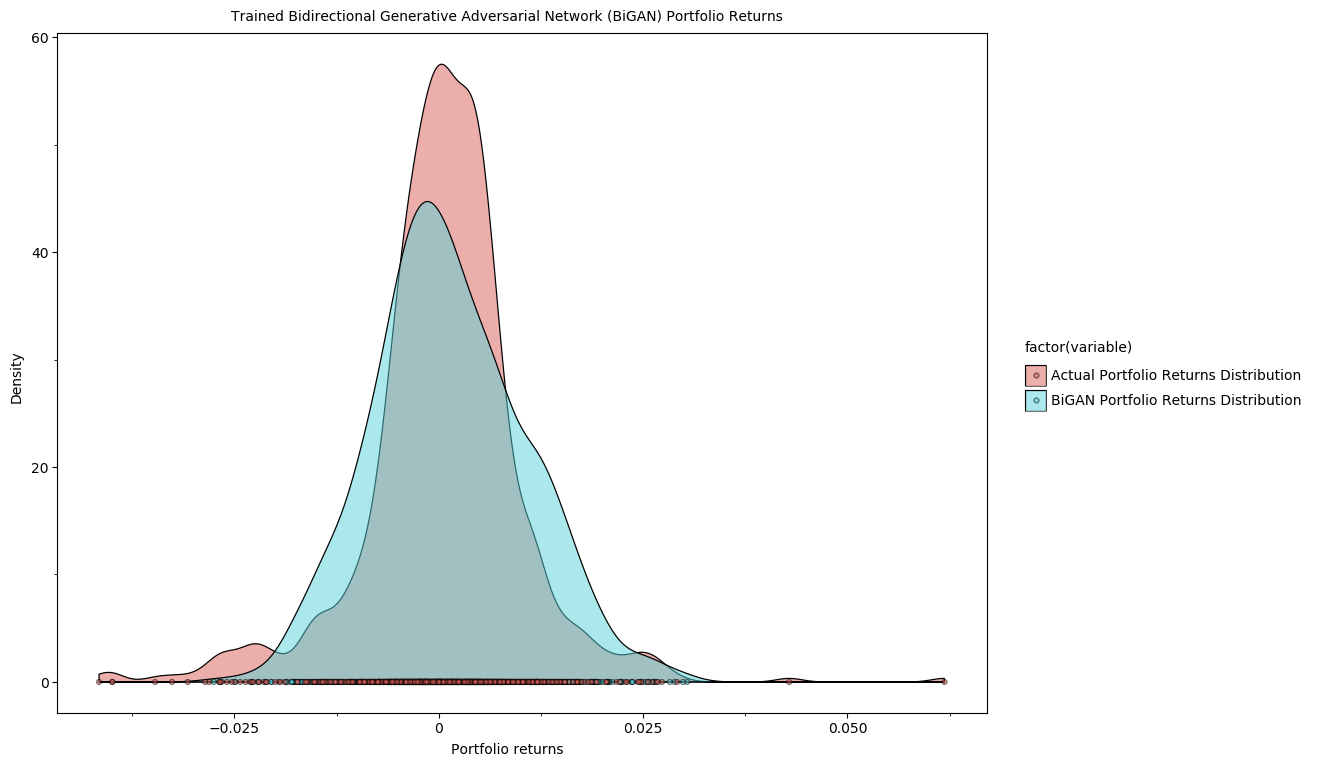